# Answering Business Questions Using SQL

## Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

db = 'chinook.db'

def run_query(query):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(query, conn)
        
def run_command(sql_command):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(sql_command)
        
def show_tables():
    query = """
                SELECT
                    name,
                    type
                FROM sqlite_master
                WHERE type IN ("table", "view");
                """
    return run_query(query)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Business Questions
### Most Popular Genres in the USA
We have to find out which genres sell the most tracks in the USA.

In [3]:
query = """
        WITH usa_tracks_sold AS
        (
         SELECT SUM(il.quantity)
         FROM invoice_line AS il
         LEFT JOIN invoice AS i ON i.invoice_id = il.invoice_id
         LEFT JOIN customer AS c ON i.customer_id = c.customer_id
         WHERE c.country = "USA"
        )
        
        SELECT
            g.name AS genre_name,
            SUM(il.quantity) AS tracks_sold,
            CAST(SUM(il.quantity) AS FLOAT) / (SELECT * FROM usa_tracks_sold) AS percentage_sold
        FROM customer c
        INNER JOIN invoice i ON c.customer_id = i.customer_id
        INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
        INNER JOIN track t ON il.track_id = t.track_id
        INNER JOIN genre g ON t.genre_id = g.genre_id
        WHERE c.country = "USA"
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10
        """

run_query(query)

,genre_name,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


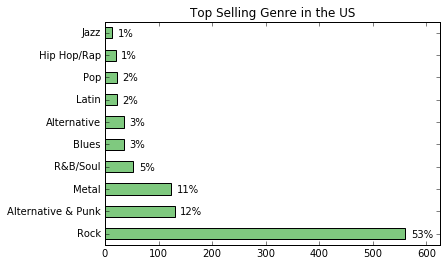

In [4]:
genre_sales_usa = run_query(query)
genre_sales_usa.set_index(keys='genre_name', drop=True, inplace=True)
genre_sales_usa['tracks_sold'].plot.barh(
    title='Top Selling Genre in the US',
    xlim=(0,625),
    colormap=plt.cm.Accent)
plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, 'tracks_sold']
    label = ((genre_sales_usa.loc[label, 'percentage_sold'] * 100)
             .astype(int).astype(str)+"%")
    plt.annotate(label, (score + 10, i-0.15))
    
plt.show()

Based on the analysis we conducted we can conclude that the top 3 most popular genres in US are Rock, Alternative & Punk and Metal.

Chinook is considering adding three from four artist to its store. Based on genre popularity in US, we would recommend to select Red Tone (Punk), Slim Jim Bites (Blues) and Meteor and the Girls (Pop).   

### Employee Performance

In [5]:
# total dollar amount of sales assigned to each sales support agent
query = """
        SELECT
            e.first_name || " " || e.last_name AS employee,
            e.hire_date,
            SUM(i.total) AS total_sales
        FROM employee AS e
        LEFT JOIN customer AS c ON e.employee_id = c.support_rep_id
        LEFT JOIN invoice AS i ON i.customer_id = c.customer_id
        WHERE e.title = "Sales Support Agent"
        GROUP BY e.employee_id
        """

run_query(query)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


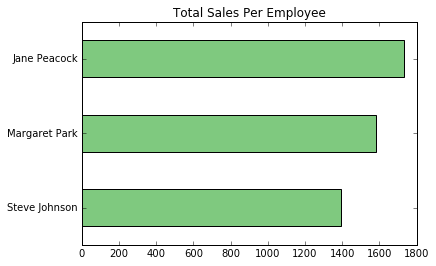

In [6]:
employee_sales = run_query(query)

employee_sales.set_index(keys='employee', drop=True, inplace=True)
employee_sales.sort_values(by='total_sales', inplace=True)
employee_sales.plot.barh(
    title="Total Sales Per Employee",
    colormap=plt.cm.Accent,
    legend=False)

plt.ylabel('')
plt.show()

While there is around 20% difference in sales between Jane Peacock (top performer) and Steve Johnson (bottom performer), this could be possibly explained by the difference in hiring dates. Johnson joined the company 6 months later than Peacock.

### Sales Data for Customers Per Country

In [7]:
query = """
        WITH country_or_other AS
            (
            SELECT
                c.country AS country,
                CASE
                    WHEN
                        count(DISTINCT c.customer_id) = 1
                    THEN "Other"
                    ELSE c.country
                END AS country_other
            FROM customer AS c
            GROUP BY c.country
            )
            
        SELECT
            country_other,
            total_customers,
            total_sales,
            average_sales_per_customer,
            average_order
        FROM
            (
            SELECT
                co.country_other,
                COUNT(DISTINCT c.customer_id) AS total_customers,
                SUM(i.total) AS total_sales,
                SUM(i.total) / COUNT(DISTINCT c.customer_id) AS average_sales_per_customer,
                AVG(i.total) AS average_order,
                CASE
                    WHEN co.country_other = "Other" THEN 1
                    ELSE 0
                END AS sort
            FROM customer AS c
            LEFT JOIN country_or_other AS co ON co.country = c.country 
            LEFT JOIN invoice AS i on i.customer_id = c.customer_id
            GROUP BY co.country_other
            )
        ORDER BY sort ASC, total_sales DESC
        """

run_query(query)

,country_other,total_customers,total_sales,average_sales_per_customer,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


### Visualizing Sales By Country

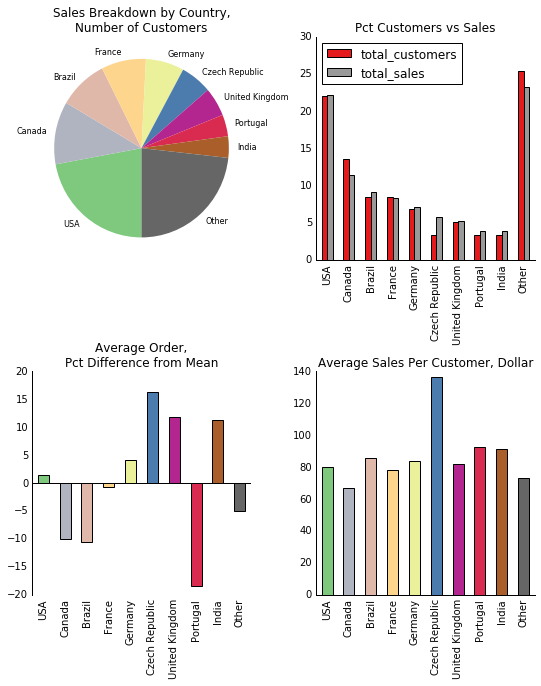

In [8]:
import numpy as np
country_metrics = run_query(query)
country_metrics.set_index(keys='country_other', drop=True, inplace=True)

colors = [plt.cm.Accent(i) for i in np.linspace(0,1,country_metrics.shape[0])]

fig, axes = plt.subplots(2, 2, figsize=(9,10))
ax1, ax2, ax3, ax4 = axes.flatten()

fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    colormap=plt.cm.Accent,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    fontsize=8,
    wedgeprops={'linewidth': 0}
)

# top right
cvs_cols = ['total_customers', 'total_sales']
cust_vs_sales = country_metrics[cvs_cols].copy()
cust_vs_sales.index.name = ''

for col in cvs_cols:
    cust_vs_sales[col] = cust_vs_sales[col]/cust_vs_sales[col].sum()*100

cust_vs_sales.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title='Pct Customers vs Sales')    
    
ax2.tick_params(top='off', bottom='off', left='off', right='off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# bottom left
avg_order = country_metrics['average_order'].copy()
avg_order.index.name = ''
difference_from_avg = avg_order/avg_order.mean()*100-100
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title='Average Order,\nPct Difference from Mean')

ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
sales_per_customer = country_metrics['average_sales_per_customer'].copy()
sales_per_customer.index.name = ''

sales_per_customer.plot.bar(
    ax=ax4,
    color=colors,
    title='Average Sales Per Customer, Dollar')

ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the analysis above, we suggest that the following countries have potential for growth:
* Czech Republic
* United Kingdom
* India

These countries have significantly higher order numbers than average, their sales volume is relatively higher than the number of customers would suggest and they also have higher average sales volume per customer.

However, it is worth to mention that our analysis is based on relatively small data. Before we heavily invest into these markets it would be recommended to run campaigns in these countries to further collect and investigate the data. This would ensure that these trends would hold with new customers as well.

### Albums vs Individual Tracks

In [9]:
album_vs_individual = """

WITH invoice_first_track AS
    (
    SELECT
        il.invoice_id AS invoice_id,
        MIN(il.track_id) AS first_track
    FROM invoice_line AS il
    GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) AS number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (SELECT CAST(COUNT(*) AS FLOAT) FROM invoice) AS percentage_of_invoices
FROM
(
    SELECT
        ift.*,
        CASE
            WHEN
                (
                SELECT track_id
                FROM track AS t
                WHERE t.album_id = (SELECT album_id
                                    FROM track
                                    WHERE track_id = ift.first_track)

                EXCEPT

                SELECT il.track_id
                FROM invoice_line AS il
                WHERE il.invoice_id = ift.invoice_id
                ) IS NULL

                AND

                (
                SELECT il.track_id
                FROM invoice_line AS il
                WHERE il.invoice_id = ift.invoice_id

                EXCEPT

                SELECT track_id
                FROM track AS t
                WHERE t.album_id = (SELECT album_id
                                    FROM track
                                    WHERE track_id = ift.first_track)
                ) IS NULL
            THEN 1
            ELSE 0
        END AS album_purchase
    FROM invoice_first_track AS ift
)
GROUP BY album_purchase
"""


run_query(album_vs_individual)

,album_purchase,number_of_invoices,percentage_of_invoices
0,0,500,0.814332
1,1,114,0.185668


18,5% of the invoices are album purchases. Based on this analysis we could recommend Chinook to continue focusing album purchases from record companies, otherwise the company would risk of losing 1/5 of its revenue.